## Импорт необходимых библиотек

In [33]:
!pip install tweet-preprocessor gensim kaggle scikit-learn optuna


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import numpy as np
import pandas as pd
import preprocessor as p
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import gensim
from sklearn.model_selection import train_test_split
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [35]:
seed = 2023
# np.random.RandomState = seed

## Анализ данных

In [36]:
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kazanova/sentiment140')

In [37]:
with zipfile.ZipFile('sentiment140.zip', 'r') as zipref:
    zipref.extractall('sentiment140/')

In [38]:
colnames=['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv("sentiment140/training.1600000.processed.noemoticon.csv", encoding='cp1252', names=colnames, header=None)
data.sample(10)

,target,ids,date,flag,user,text
88177,0,1754759836,Sun May 10 07:18:05 PDT 2009,NO_QUERY,Lindsey_Girly,Going to my Grandmas to celebrate Mothers day....
1356010,4,2047655555,Fri Jun 05 13:58:50 PDT 2009,NO_QUERY,gunandagirl,"@JDollin Oh trust me, she'll be moving into my..."
1138060,4,1976808834,Sat May 30 19:08:19 PDT 2009,NO_QUERY,Yayitsmartyna,@buggi30 watched willly wonka too
1597750,4,2193007465,Tue Jun 16 07:52:02 PDT 2009,NO_QUERY,withinwithout,@john_garza nice! enjoy.... i do love the home...
1291195,4,2002856252,Tue Jun 02 05:19:47 PDT 2009,NO_QUERY,gailelaine,"@azmomofmanyhats Yep, it's another great day! ..."
243211,0,1981493728,Sun May 31 09:16:11 PDT 2009,NO_QUERY,ChelseaArchibal,@naomiwallace i still don't have one
1061905,4,1963931557,Fri May 29 13:28:06 PDT 2009,NO_QUERY,Kamthenikhil,@WATblog wat consultants is doin quite wel on ...
1376929,4,2051815394,Fri Jun 05 22:52:56 PDT 2009,NO_QUERY,Sky_Breaker,OOC: *hugs everybot within range and tosses ch...
716350,0,2259672510,Sat Jun 20 17:58:35 PDT 2009,NO_QUERY,whispersoftime,Boo...my tummy hurts again
751870,0,2286262055,Mon Jun 22 16:12:28 PDT 2009,NO_QUERY,gdee73,My condolences to those who have lost loved on...


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [40]:
data.drop(['ids', 'date', 'flag', 'user'], axis=1, inplace=True)
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


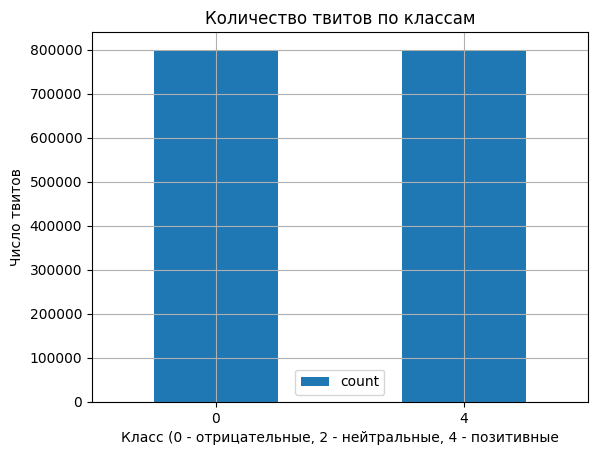

In [41]:
data['target'].value_counts().plot(
    kind='bar',
    rot=0,
    title='Количество твитов по классам',
    xlabel='Класс (0 - отрицательные, 2 - нейтральные, 4 - позитивные',
    ylabel='Число твитов',
    legend=True,
    grid=True
);

Класса получается всего 2, поэтому мы будем делать бинарную классификацию. Заменим метку класса 4 на 1:

In [42]:
data['target'] = data['target'].replace(4,1)

## Предобработка данных

In [43]:
print(STOPWORDS)

frozenset({'been', 'were', 'again', 'him', 'further', 're', 'thin', 'cannot', 'so', 'moreover', 'already', 'somewhere', 'forty', 'towards', 'everything', 'system', 'an', 'myself', 'still', 'out', 'toward', 'until', 'meanwhile', 'without', 'either', 'themselves', 'whenever', 'how', 'any', 'eleven', 'formerly', 'ourselves', 'etc', 'these', 'hereupon', 'am', 'our', 'all', 'nothing', 'could', 'none', 'only', 'part', 'alone', 'become', 'amount', 'of', 'me', 'he', 'doesn', 'after', 'before', 'same', 'yourselves', 'really', 'those', 'though', 'becoming', 'when', 'see', 'un', 'thence', 'top', 'because', 'namely', 'indeed', 'should', 'last', 'both', 'through', 'she', 'give', 'whether', 'at', 'hence', 'now', 'anywhere', 'across', 'another', 'eight', 'cant', 'say', 'on', 'some', 'around', 'becomes', 'too', 'which', 'amongst', 'his', 'against', 'get', 'whither', 'itself', 'then', 'empty', 'three', 'enough', 'former', 'ltd', 'ours', 'with', 'thick', 'due', 'there', 'than', 'upon', 'whereafter', 'ho

Данные стоп слова вряд ли влияют на настроение твита, так что возьму их прямо из коробки.

In [44]:
%%time
def preprocess_tweet(row):
    text = row['text']
    text = p.clean(text)
    text = remove_stopwords(text)
    return text.lower().replace('\s\s+', ' ')

data['cleaned_text'] = data.apply(preprocess_tweet, axis=1)

CPU times: total: 2min 46s
Wall time: 2min 46s


In [45]:
data.sample(10)

,target,text,cleaned_text
248463,0,just went to bebo with the intention of closin...,went bebo intention closing account i couldn't...
15846,0,Swisher didn't pitch Jays won again!,swisher didn't pitch jays won again!
920662,1,lol so boredd nithing to do someone SAVE ME PL...,lol boredd nithing save me please
641337,0,Actual last day of college!! Pity it has to f...,actual day college!! pity finish drama exam......
29822,0,"@__Anya__ not just you, love. its a LOT of pe...","you, love. lot people"
491402,0,@stephaniepratt The contact form on your websi...,the contact form website isn't working any way...
1489,0,@adreamforsteph ok House was sad.,ok house sad.
1524360,1,@Djalise Heyyy !!! I wish you an Happy Happy B...,heyyy !!! i wish happy happy birthday !!!!!!!!
1170625,1,@diet_tay oh @ Megabus. Rather you than me! Bu...,oh megabus. rather me! but bring toma...
272220,0,"Aww...nancy, i'll miss you","aww...nancy, i'll miss"


## Извлечение признаков из текста с помощью векторизации

In [46]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['target'], random_state=2023)

In [47]:
%%time
VECTOR_SIZE = 256
model = gensim.models.FastText(
    sentences=X_train,
    vector_size=VECTOR_SIZE, # default = 100
    window=7, # default = 5
    min_count=10,
    sg=1, # Training algorithm: 1 for skip-gram; otherwise CBOW
    hs=0, #  If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
    negative=5, # If > 0, negative sampling will be used, if set to 0, no negative sampling is used.
    epochs=25, # Number of iterations (epochs) over the corpus
    seed=seed,
)

CPU times: total: 51min 32s
Wall time: 18min 3s


In [48]:
# Получаем эмбеддинг для текста
def document_vector(doc):
    doc = [model.wv[word] for word in doc if word in model.wv.key_to_index.keys()]
    if not doc:
        return [0 for i in range(VECTOR_SIZE)]
    return np.mean(doc, axis=0)

X_train_vectorized = list(X_train.apply(document_vector))
X_test_vectorized = list(X_test.apply(document_vector))

## Бейзлайн - константное предсказание

In [49]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=seed).fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    199541
           1       0.00      0.00      0.00    200459

    accuracy                           0.50    400000
   macro avg       0.25      0.50      0.33    400000
weighted avg       0.25      0.50      0.33    400000



## Логистическая регрессия

In [53]:
logreg = LogisticRegression(random_state=seed, max_iter=1000).fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61    199541
           1       0.61      0.55      0.58    200459

    accuracy                           0.60    400000
   macro avg       0.60      0.60      0.60    400000
weighted avg       0.60      0.60      0.60    400000



## SVM и RandomForest

In [54]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["SVC", "RandomForest"])
    if classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-10, 1e10)
        classifier_obj = SVC(C=svc_c, gamma="auto", random_state=seed)
    else:
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32)
        classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10, random_state=seed)

    score = cross_val_score(classifier_obj, X_test_vectorized, y_test, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2023-12-28 23:51:08,789] A new study created in memory with name: no-name-fa270dce-8057-47ea-aacb-d5cc0edf4c6e


In [ ]:
print(study.best_trial)

In [ ]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_slice

plot_slice(study)